In [1]:
#!pip install torch
#packages 
#Load packages :pytorch, sklearn etc.,
import numpy as np
import pandas as pd
import random
import os

import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets

from sklearn import metrics
from sklearn import decomposition
from sklearn import manifold
from tqdm.notebook import trange, tqdm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import copy
import time


In [2]:
#reading in the .npz file to train the model 
def get_training_data(load=False, datafile ='test.npz'):
    
    if not load:
        # This grabs the training data files from the appropriate directory
        mypath = './DS440-CAPSTONE/'
        training_data_files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
        
        training_t = []  
        training_f = []
        training_class = []
        training_info = []
        for f in training_data_files:
            data = np.load(mypath+f)
            all_time=data['all_time']
            all_flux=data['all_flux']
            ra = data['ra']
            dec = data['dec']
            injmu_percentile=data['injmu_percentile']
            injduration=data['injduration']
            injloc_x=-1 * data['injloc_x']
            injloc_y=-1 * data['injloc_y']
            injpeak=data['injpeak']
            
            info = ra,dec,injmu_percentile,injduration,injloc_x,injloc_y,injpeak #injduration, injpeak
            for i, t in enumerate(all_time):
                f = all_flux[i]
                row = np.floor(i/9) - 4
                col = i%9 - 4
                if np.all(np.isnan(f)):
                    continue
                if np.sqrt((row - injloc_x)**2 + (col-injloc_y)**2)<=2:
                    training_t.append(t)
                    training_f.append(f)
                    training_class.append(1)
                    training_info.append(info)
                    
                elif np.sqrt((row - injloc_x)**2 + (col-injloc_y)**2)>5:
                    training_t.append(t)
                    training_f.append(f)
                    training_class.append(0)
                    training_info.append(info)
        np.savez(datafile,training_t = training_t, training_f = training_f,
                training_class = training_class, training_info = training_info)
        return training_t, training_f,training_class,training_info
    else:
        data = np.load(datafile, allow_pickle=True)
        training_t = data['training_t']         # needs to be padded and then shuffled
        training_f = data['training_f']         
        training_class = data['training_class']  
        training_info = data['training_info']   
        return training_t, training_f,training_class,training_info
training_t, training_f,training_class,training_info = get_training_data(load=True)

In [3]:
#padding the arrays to match the max size
longest_len = 3658
for i in np.arange(len(training_t)):
    mylen = len(training_t[i])
    if mylen>longest_len:
        longest_len = mylen
new_training_t = np.zeros((len(training_t),longest_len))
new_training_f = np.zeros((len(training_t),longest_len))
for i in np.arange(len(training_t)):
    nl = len(training_t[i])
    before_N=int(longest_len/2-(nl/2))
    new_training_t[i,before_N:nl+before_N] = training_t[i]   # Data to be used
    new_training_f[i,before_N:nl+before_N] = training_f[i]   # Data to be used

In [4]:
float_nt_f = new_training_f.astype(np.float64)

In [5]:
type(float_nt_f)

numpy.ndarray

In [6]:
float_nt_f

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
new_training_f.shape

(12116, 3658)

In [8]:
training_class.shape

(12116,)

In [9]:
# introducing balanced dataset 

#new set with 50/50 SNe
count_arr = np.bincount(training_class)
count1 = count_arr[1]
count0 = count_arr[0]

#get index of 0's, 1's-> np.where 
#np.random.choice?(replace= False ) returns a random sample of zeroes. 

zero=np.where(training_class==0)[0]  # the [0] just means the first "element" in this case array is selected. np.where makes a matrix of size nx2 for some reason 
one = np.where(training_class==1)[0] 
#get the indexes
train_c0 = np.random.choice(zero, size=2383, replace=False, p=None)
train_f0 = new_training_f[train_c0]
train_c00= training_class[train_c0]

train_f1 = new_training_f[one]
train_c11 = training_class[one]

train_c_all = np.append(train_c00,train_c11)
train_f_all = np.vstack((train_f0,train_f1))

In [10]:
class CustomDataset(data.Dataset):
    def __init__(self, train_c_all, train_f_all, transform=None, target_transform=None):   #train_c_all,train_f_all -                                                                                    
        self.labels = train_c_all                                                         #from balanced set 
        self.data = train_f_all
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        #img_path = os.path.join(self.data, self.labels.iloc[idx, 0])
        curve = self.data[idx]
        label = self.labels[idx]
        if self.transform:
            curve = self.transform(curve)
        if self.target_transform:
            label = self.target_transform(label)
        return curve, label

In [11]:
train = CustomDataset(training_class, float_nt_f, transform=None, target_transform=None)

In [12]:
VALID_RATIO = 0.9
TEST_RATIO = 0.66

n_train_examples = int(len(train) * TEST_RATIO)
n_test_examples = len(train) - n_train_examples
n_train_examples = int(n_train_examples * VALID_RATIO)
n_valid_examples = len(train) - n_test_examples - n_train_examples

In [13]:
train_data, test_data, valid_data = data.random_split(train, [n_train_examples, n_test_examples, n_valid_examples])

In [14]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, batch_size=BATCH_SIZE)

test_iterator = data.DataLoader(test_data, batch_size=BATCH_SIZE)

In [15]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 1400)
        self.hidden_fc1 = nn.Linear(1400, 530)
        self.hidden_fc2 = nn.Linear(530, 200)
        self.hidden_fc3 = nn.Linear(200, 80)
        self.output_fc = nn.Linear(80, output_dim)

    def forward(self, x):

        # x = [batch size, height, width]

        batch_size = x.shape[0]

        x = x.view(batch_size, -1)

        # x = [batch size, height * width]

        h_1 = F.relu(self.input_fc(x))

        # h_1 = [batch size, 1400]

        h_2 = F.relu(self.hidden_fc1(h_1))

        # h_2 = [batch size, 530]
        
        h_3 = F.relu(self.hidden_fc2(h_2))

        # h_3 = [batch size, 200]
        
        h_4 = F.relu(self.hidden_fc3(h_3))

        # h_4 = [batch size, 80]

        y_pred = self.output_fc(h_4)

        # y_pred = [batch size, output dim]

        return y_pred, h_4

define our model by creating an instance of it and setting the correct input and output dimensions.

In [16]:
INPUT_DIM = 3658
OUTPUT_DIM = 2

model = MLP(INPUT_DIM, OUTPUT_DIM)

calculate the number of trainable parameters

In [17]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

The first layer has 3658 neurons connected to 1400 neurons, so 3658*1400 weighted connections plus 1400 bias terms.

The second layer has 1400 neurons connected to 530 neurons, 1400*530 weighted connections plus 530 bias terms.

The third layer has 530 neurons connected to 200 neurons, 530*200 weighted connections plus 200 bias terms.

The fourth layer has 200 neurons connected to 80 neurons, 200*80 weighted connections plus 80 bias terms.

The fifth layer has 80 neurons connected to 2 neurons, 80*2 weighted connections plus 2 bias terms.

$$3658 \cdot 1400 + 1400 + 1400 \cdot 530 + 530 + 530 \cdot 200 + 200 + 200 \cdot 80 + 80 + 80 \cdot 2 + 2 = 5,987,572 $$

In [18]:
print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 5,987,572 trainable parameters


In [19]:
optimizer = optim.Adam(model.parameters())

In [20]:
criterion = nn.CrossEntropyLoss()

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [22]:
model = model.to(device)
criterion = criterion.to(device)

In [23]:
def calculate_accuracy(y_pred, y):
    top_pred = y_pred.argmax(1, keepdim=True)
    correct = top_pred.eq(y.view_as(top_pred)).sum()
    acc = correct.float() / y.shape[0]
    return acc

In [24]:
def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x.float())

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [33]:
def train_no_tqdm(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for (x, y) in iterator:

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x.float())

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [34]:
def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x.float())

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [35]:
def evaluate_no_tqdm(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x.float())

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()

    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [26]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [27]:
EPOCHS = 10

best_valid_loss = float('inf')

for epoch in trange(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

  0%|          | 0/10 [00:00<?, ?it/s]

Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 01 | Epoch Time: 0m 5s
	Train Loss: 0.473 | Train Acc: 93.34%
	 Val. Loss: 0.200 |  Val. Acc: 94.35%


Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 02 | Epoch Time: 0m 0s
	Train Loss: 0.174 | Train Acc: 96.02%
	 Val. Loss: 0.081 |  Val. Acc: 98.32%


Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 03 | Epoch Time: 0m 0s
	Train Loss: 0.174 | Train Acc: 95.68%
	 Val. Loss: 0.412 |  Val. Acc: 96.51%


Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 04 | Epoch Time: 0m 0s
	Train Loss: 0.098 | Train Acc: 97.95%
	 Val. Loss: 0.054 |  Val. Acc: 98.80%


Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 05 | Epoch Time: 0m 0s
	Train Loss: 2.075 | Train Acc: 95.89%
	 Val. Loss: 0.173 |  Val. Acc: 97.48%


Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 06 | Epoch Time: 0m 0s
	Train Loss: 0.202 | Train Acc: 96.61%
	 Val. Loss: 0.349 |  Val. Acc: 97.12%


Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 07 | Epoch Time: 0m 0s
	Train Loss: 0.641 | Train Acc: 93.84%
	 Val. Loss: 1.170 |  Val. Acc: 84.01%


Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 08 | Epoch Time: 0m 0s
	Train Loss: 0.355 | Train Acc: 95.53%
	 Val. Loss: 0.049 |  Val. Acc: 98.92%


Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 09 | Epoch Time: 0m 0s
	Train Loss: 0.093 | Train Acc: 97.12%
	 Val. Loss: 0.074 |  Val. Acc: 97.72%


Training:   0%|          | 0/113 [00:00<?, ?it/s]

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Epoch: 10 | Epoch Time: 0m 0s
	Train Loss: 0.050 | Train Acc: 98.47%
	 Val. Loss: 0.036 |  Val. Acc: 98.92%


In [28]:
##rename the .pt file

#model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

In [29]:
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.047 | Test Acc: 98.64%


## Hyperparameter Tuning

In [63]:
BATCH_SIZES = [64, 120, 200, 400, 600, 1200]
EPOCHS = [10, 20, 30, 40]

tuning_data = {
    "Batch Size": [],
    "Epoch Count": [],
    "Current Epoch": [],
    "Train Loss": [],
    "Train Acc": [],
    "Val Loss": [],
    "Val Acc": []
}
tuning_data = pd.DataFrame(tuning_data)

best_valid_loss = float('inf')


for b in BATCH_SIZES:
    train_it = data.DataLoader(train_data, shuffle=True, batch_size=b)
    valid_it = data.DataLoader(valid_data, batch_size=b)
    
    for e in EPOCHS:
        print(f'Batch Size: {b} | Epoch Count: {e}')
        start_time = time.monotonic()
        
        for epoch in trange(e):

            train_loss, train_acc = train_no_tqdm(model, train_it, optimizer, criterion, device)
            valid_loss, valid_acc = evaluate_no_tqdm(model, valid_it, criterion, device)
            
            temp = pd.Series(data={"Batch Size": b, "Epoch Count": e, "Current Epoch": epoch, "Train Loss": train_loss, "Train Acc": train_acc, "Val Loss": valid_loss, "Val Acc": valid_acc})
            tuning_data = tuning_data.append(temp, ignore_index=True)

            if valid_loss < best_valid_loss:
                best_valid_loss = valid_loss
                torch.save(model.state_dict(), 'tut1-model.pt')
                print(f'best: {b} | {e}')
            
            if epoch % 5 == 0:
                print(f'\tEpoch: {epoch+1:02}')

                
        end_time = time.monotonic()
        mins, secs = epoch_time(start_time, end_time)

        print(f'Model Train Time: {mins}m {secs}s')

Batch Size: 64 | Epoch Count: 10


  0%|          | 0/10 [00:00<?, ?it/s]

best: 64 | 10
	Epoch: 01
	Epoch: 06
Model Train Time: 0m 6s
Batch Size: 64 | Epoch Count: 20


  0%|          | 0/20 [00:00<?, ?it/s]

	Epoch: 01
	Epoch: 06
	Epoch: 11
	Epoch: 16
Model Train Time: 0m 13s
Batch Size: 64 | Epoch Count: 30


  0%|          | 0/30 [00:00<?, ?it/s]

	Epoch: 01
	Epoch: 06
	Epoch: 11
	Epoch: 16
	Epoch: 21
	Epoch: 26
Model Train Time: 0m 20s
Batch Size: 64 | Epoch Count: 40


  0%|          | 0/40 [00:00<?, ?it/s]

	Epoch: 01
	Epoch: 06
	Epoch: 11
	Epoch: 16
	Epoch: 21
	Epoch: 26
	Epoch: 31
	Epoch: 36
Model Train Time: 0m 27s
Batch Size: 120 | Epoch Count: 10


  0%|          | 0/10 [00:00<?, ?it/s]

	Epoch: 01
	Epoch: 06
Model Train Time: 0m 4s
Batch Size: 120 | Epoch Count: 20


  0%|          | 0/20 [00:00<?, ?it/s]

	Epoch: 01
	Epoch: 06
	Epoch: 11
	Epoch: 16
Model Train Time: 0m 8s
Batch Size: 120 | Epoch Count: 30


  0%|          | 0/30 [00:00<?, ?it/s]

	Epoch: 01
	Epoch: 06
	Epoch: 11
	Epoch: 16
	Epoch: 21
	Epoch: 26
Model Train Time: 0m 13s
Batch Size: 120 | Epoch Count: 40


  0%|          | 0/40 [00:00<?, ?it/s]

	Epoch: 01
	Epoch: 06
	Epoch: 11
	Epoch: 16
	Epoch: 21
	Epoch: 26
	Epoch: 31
best: 120 | 40
	Epoch: 36
best: 120 | 40
best: 120 | 40
best: 120 | 40
best: 120 | 40
Model Train Time: 0m 18s
Batch Size: 200 | Epoch Count: 10


  0%|          | 0/10 [00:00<?, ?it/s]

	Epoch: 01
best: 200 | 10
best: 200 | 10
best: 200 | 10
best: 200 | 10
best: 200 | 10
	Epoch: 06
Model Train Time: 0m 3s
Batch Size: 200 | Epoch Count: 20


  0%|          | 0/20 [00:00<?, ?it/s]

	Epoch: 01
best: 200 | 20
best: 200 | 20
best: 200 | 20
best: 200 | 20
	Epoch: 06
	Epoch: 11
best: 200 | 20
best: 200 | 20
best: 200 | 20
best: 200 | 20
	Epoch: 16
best: 200 | 20
Model Train Time: 0m 7s
Batch Size: 200 | Epoch Count: 30


  0%|          | 0/30 [00:00<?, ?it/s]

	Epoch: 01
	Epoch: 06
	Epoch: 11
	Epoch: 16
	Epoch: 21
	Epoch: 26
Model Train Time: 0m 10s
Batch Size: 200 | Epoch Count: 40


  0%|          | 0/40 [00:00<?, ?it/s]

	Epoch: 01
	Epoch: 06
	Epoch: 11
	Epoch: 16
	Epoch: 21
	Epoch: 26
	Epoch: 31
	Epoch: 36
Model Train Time: 0m 13s
Batch Size: 400 | Epoch Count: 10


  0%|          | 0/10 [00:00<?, ?it/s]

	Epoch: 01
	Epoch: 06
Model Train Time: 0m 2s
Batch Size: 400 | Epoch Count: 20


  0%|          | 0/20 [00:00<?, ?it/s]

	Epoch: 01
	Epoch: 06
	Epoch: 11
	Epoch: 16
Model Train Time: 0m 5s
Batch Size: 400 | Epoch Count: 30


  0%|          | 0/30 [00:00<?, ?it/s]

	Epoch: 01
	Epoch: 06
	Epoch: 11
	Epoch: 16
	Epoch: 21
	Epoch: 26
Model Train Time: 0m 8s
Batch Size: 400 | Epoch Count: 40


  0%|          | 0/40 [00:00<?, ?it/s]

	Epoch: 01
	Epoch: 06
	Epoch: 11
	Epoch: 16
	Epoch: 21
	Epoch: 26
	Epoch: 31
	Epoch: 36
Model Train Time: 0m 10s
Batch Size: 600 | Epoch Count: 10


  0%|          | 0/10 [00:00<?, ?it/s]

	Epoch: 01
	Epoch: 06
Model Train Time: 0m 2s
Batch Size: 600 | Epoch Count: 20


  0%|          | 0/20 [00:00<?, ?it/s]

	Epoch: 01
	Epoch: 06
	Epoch: 11
	Epoch: 16
Model Train Time: 0m 4s
Batch Size: 600 | Epoch Count: 30


  0%|          | 0/30 [00:00<?, ?it/s]

	Epoch: 01
	Epoch: 06
	Epoch: 11
	Epoch: 16
	Epoch: 21
	Epoch: 26
Model Train Time: 0m 7s
Batch Size: 600 | Epoch Count: 40


  0%|          | 0/40 [00:00<?, ?it/s]

	Epoch: 01
	Epoch: 06
	Epoch: 11
	Epoch: 16
	Epoch: 21
	Epoch: 26
	Epoch: 31
	Epoch: 36
Model Train Time: 0m 9s
Batch Size: 1200 | Epoch Count: 10


  0%|          | 0/10 [00:00<?, ?it/s]

	Epoch: 01
	Epoch: 06
Model Train Time: 0m 2s
Batch Size: 1200 | Epoch Count: 20


  0%|          | 0/20 [00:00<?, ?it/s]

	Epoch: 01
	Epoch: 06
	Epoch: 11
	Epoch: 16
Model Train Time: 0m 4s
Batch Size: 1200 | Epoch Count: 30


  0%|          | 0/30 [00:00<?, ?it/s]

	Epoch: 01
	Epoch: 06
	Epoch: 11
	Epoch: 16
	Epoch: 21
	Epoch: 26
Model Train Time: 0m 6s
Batch Size: 1200 | Epoch Count: 40


  0%|          | 0/40 [00:00<?, ?it/s]

	Epoch: 01
	Epoch: 06
	Epoch: 11
	Epoch: 16
	Epoch: 21
	Epoch: 26
	Epoch: 31
	Epoch: 36
Model Train Time: 0m 8s


### Best Model Testing

In [87]:
model.load_state_dict(torch.load('tut1-model.pt'))

test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Evaluating:   0%|          | 0/65 [00:00<?, ?it/s]

Test Loss: 0.280 | Test Acc: 98.49%


In [64]:
tuning_data

,Batch Size,Epoch Count,Current Epoch,Train Loss,Train Acc,Val Loss,Val Acc
0,64.0,10.0,0.0,0.130694,0.946271,0.135712,0.94351
1,64.0,10.0,1.0,0.130328,0.946448,0.135723,0.94351
2,64.0,10.0,2.0,0.130944,0.946093,0.135719,0.94351
3,64.0,10.0,3.0,0.130740,0.946271,0.135719,0.94351
4,64.0,10.0,4.0,0.130197,0.946626,0.135721,0.94351
...,...,...,...,...,...,...,...
595,1200.0,40.0,35.0,0.107420,0.960255,0.110602,0.95875
596,1200.0,40.0,36.0,0.107415,0.960257,0.110602,0.95875
597,1200.0,40.0,37.0,0.107409,0.960263,0.110601,0.95875
598,1200.0,40.0,38.0,0.107428,0.960250,0.110601,0.95875


In [122]:
param_sets = []
bs = []
es = []
for b in BATCH_SIZES:
    for e in EPOCHS:
        temp = tuning_data.loc[(tuning_data['Batch Size'] == b) & (tuning_data['Epoch Count'] == e)]
        param_sets.append(temp)
        bs.append(b)
        es.append(e)

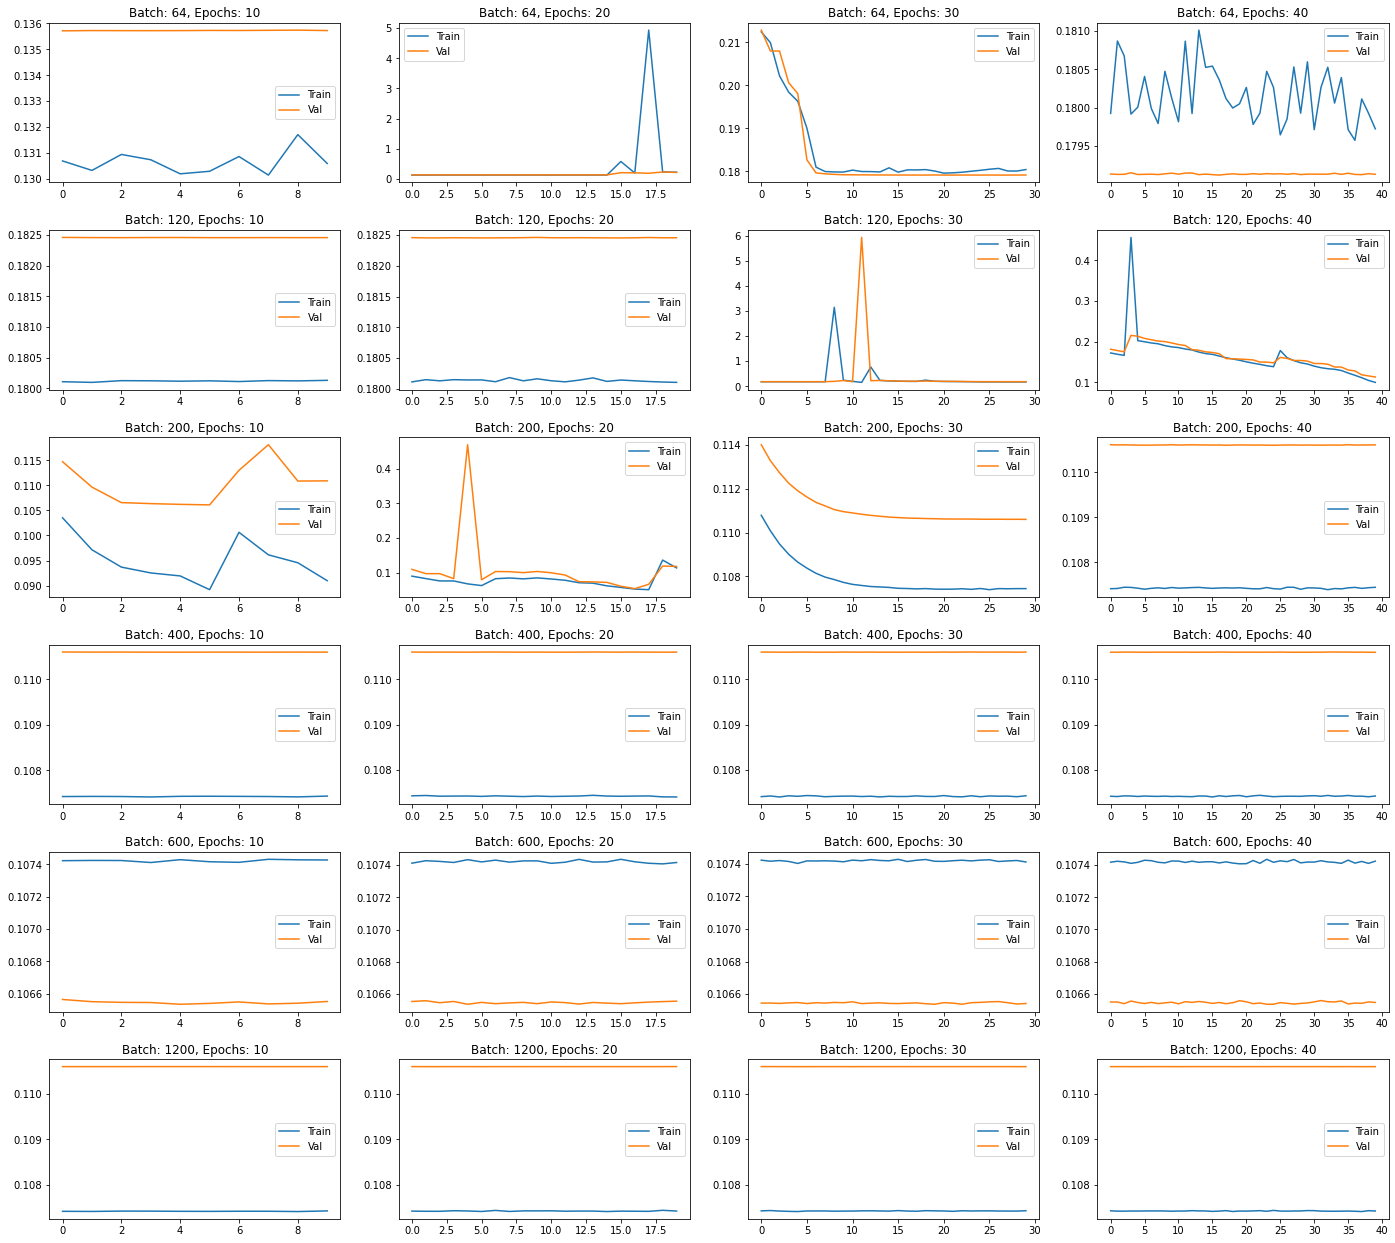

In [137]:

figure, axis = plt.subplots(6, 4, figsize=(24, 22))
plt.subplots_adjust(hspace=0.3)

for i in range(24):
    axis[int(i/4),i%4].plot(param_sets[i].loc[:,"Current Epoch"], param_sets[i].loc[:,"Train Loss"], label = "Train")
    axis[int(i/4),i%4].plot(param_sets[i].loc[:,"Current Epoch"], param_sets[i].loc[:,"Val Loss"], label = "Val")
    axis[int(i/4),i%4].set_title(f"Batch: {bs[i]}, Epochs: {es[i]}")
    axis[int(i/4),i%4].legend()



In [141]:
#param_sets[1]

In [140]:
#param_sets[6]

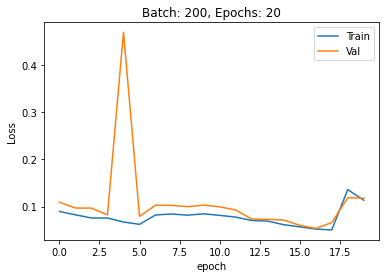

In [102]:
plt.plot(param_sets[9].loc[:,"Current Epoch"], param_sets[9].loc[:,"Train Loss"], label = "Train")
plt.plot(param_sets[9].loc[:,"Current Epoch"], param_sets[9].loc[:,"Val Loss"], label = "Val")
plt.legend()
plt.ylabel("Loss")
plt.xlabel("epoch")
plt.title("Batch: 200, Epochs: 20")
plt.show()

## Examining the model

In [68]:
def get_predictions(model, iterator, device):

    model.eval()

    images = []
    labels = []
    probs = []

    with torch.no_grad():

        for (x, y) in iterator:

            x = x.to(device)

            y_pred, _ = model(x.float())

            y_prob = F.softmax(y_pred, dim=-1)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

In [69]:
images, labels, probs = get_predictions(model, test_iterator, device)

pred_labels = torch.argmax(probs, 1)

In [70]:
def plot_confusion_matrix(labels, pred_labels):

    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(1, 1, 1)
    cm = metrics.confusion_matrix(labels, pred_labels)
    cm = metrics.ConfusionMatrixDisplay(cm, display_labels=range(10))
    cm.plot(values_format='d', cmap='Blues', ax=ax)

ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of ticklabels (10).

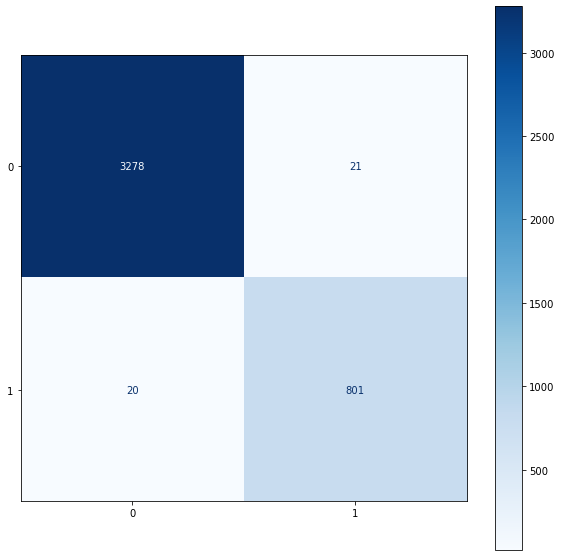

In [71]:
plot_confusion_matrix(labels, pred_labels)

In [72]:
# conclusion kinda did worse than before?
# the data being already imbalanced 
# next to 

In [73]:
#reading in a small test set with real SNe to see how the model actually performs.
# Some actual testing on SNe = test_sn.npz
#read in the data 
def get_testing_data(load=False, datafile ='testdata_set(1).npz'):
    
    if not load:
        # This grabs the training data files from the appropriate directory
        mypath = './pipelinefile_/'
        training_data_files = [f for f in listdir(mypath) if isfile(join(mypath, f))]
        
        test_t = []  
        test_f = []
        test_class = []
        test_info = []
        for f in training_data_files:
            data = np.load(mypath+f)
            all_time=data['all_time']
            all_flux=data['all_flux']
            ra = data['ra']
            dec = data['dec']
            injmu_percentile=data['injmu_percentile']
            injduration=data['injduration']
            injloc_x=-1 * data['injloc_x']
            injloc_y=-1 * data['injloc_y']
            injpeak=data['injpeak']
            
            info = ra,dec,injmu_percentile,injduration,injloc_x,injloc_y,injpeak #injduration, injpeak
            for i, t in enumerate(all_time):
                f = all_flux[i]
                row = np.floor(i/9) - 4
                col = i%9 - 4
                if np.all(np.isnan(f)):
                    continue
                if np.sqrt((row - injloc_x)**2 + (col-injloc_y)**2)<=2:
                    test_t.append(t)
                    test_f.append(f)
                    test_class.append(1)
                    test_info.append(info)
                    
                elif np.sqrt((row - injloc_x)**2 + (col-injloc_y)**2)>5:
                    test_t.append(t)
                    test_f.append(f)
                    test_class.append(0)
                    test_info.append(info)
        np.savez(datafile,testg_t = test_t, test_f = test_f,
                test_class = test_class, test_info = test_info)
        return test_t, test_f,test_class,test_info
    else:
        data = np.load(datafile, allow_pickle=True)
        test_t = data['training_t']         # needs to be padded and then shuffled
        test_f = data['training_f']         
        test_class = data['training_class']  
        test_info = data['training_info']   
        return test_t, test_f,test_class,test_info
test_t, test_f,test_class,test_info = get_testing_data(load=True)


In [74]:
#adding padding to the curves
Xtest = np.array(test_f)
Ytest = np.array(test_class)

longest_len = 3658
for i in np.arange(len(Xtest)): 
    mylen = len(Xtest[i]) 
    if mylen>longest_len:
        longest_len = mylen
new_f = np.zeros((len(Xtest),longest_len)) 
for i in np.arange(len(Xtest)): 
    nl = len(Xtest[i]) 
    before_N=int(longest_len/2-(nl/2))
    new_f[i,before_N:nl+before_N] = Xtest[i]  
    

In [75]:
# normalize the fluxes!! Imp step 
scaler = MinMaxScaler()
xtest = scaler.fit_transform(new_f.T).T  # might not work here just yet

In [107]:
temp = CustomDataset(Ytest, xtest, transform=None, target_transform=None)

In [112]:
temp[0:2]

(array([[0.32443337, 0.32443337, 0.32443337, ..., 0.32443337, 0.32443337,
         0.32443337],
        [0.47590155, 0.47590155, 0.47590155, ..., 0.47590155, 0.47590155,
         0.47590155]]),
 array([0, 1], dtype=int64))

In [113]:
real_test_iterator = data.DataLoader(temp, batch_size=BATCH_SIZE)

In [114]:
real_images, real_labels, real_probs = get_predictions(model, real_test_iterator, device)

real_pred_labels = torch.argmax(real_probs, 1)

ValueError: The number of FixedLocator locations (2), usually from a call to set_ticks, does not match the number of ticklabels (10).

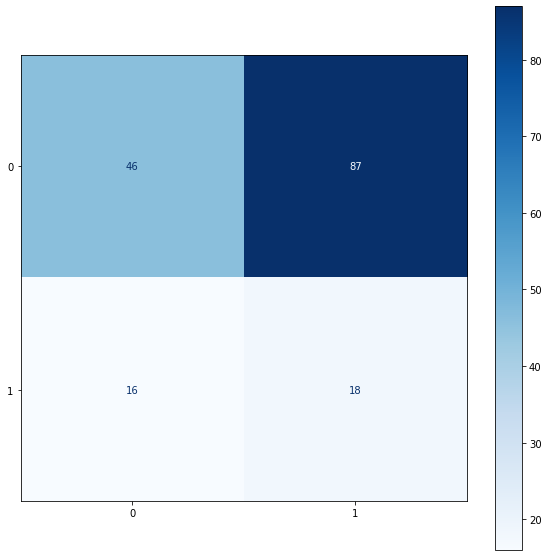

In [115]:
plot_confusion_matrix(real_labels, real_pred_labels)